# COVID-19's $R_t$ in Real-Time, with Obesity Data.
A lot of code from Kevin Systrom - April 22

Model originally built by [Thomas Vladeck](https://github.com/tvladeck) in Stan, parts inspired by the work over at https://epiforecasts.io/, lots of help from [Thomas Wiecki](https://twitter.com/twiecki). Thank you to everyone who helped.

This notebook is a WIP - I'll add more context and commentary over the coming week.

Obesity data added by Michael Verano.
Source: www.cdc.gov/obesity/data/prevalence-maps.html

In [1]:
# For some reason Theano is unhappy when I run the GP, need to disable future warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import os
import requests
import pymc3 as pm
import pandas as pd
import numpy as np
import theano
import theano.tensor as tt

from matplotlib import pyplot as plt
from matplotlib import dates as mdates
from matplotlib import ticker

from datetime import date
from datetime import datetime

from IPython.display import clear_output

%config InlineBackend.figure_format = 'retina'

## Load State Information
#### Load

In [2]:
url = 'https://covidtracking.com/api/v1/states/daily.csv'
states = pd.read_csv(url,
                     parse_dates=['date'],
                     index_col=['state', 'date']).sort_index()

# Note: GU/AS/VI do not have enough data for this model to run


# Note: PR had -384 change recently in total count so unable to model
states = states.drop(['MP', 'GU', 'AS', 'PR', 'VI'])

#### Clean data with known modifications

In [3]:
# Errors in Covidtracking.com
states.loc[('WA','2020-04-21'), 'positive'] = 12512
states.loc[('WA','2020-04-22'), 'positive'] = 12753 
states.loc[('WA','2020-04-23'), 'positive'] = 12753 + 190

states.loc[('VA', '2020-04-22'), 'positive'] = 10266
states.loc[('VA', '2020-04-23'), 'positive'] = 10988

states.loc[('PA', '2020-04-22'), 'positive'] = 35684
states.loc[('PA', '2020-04-23'), 'positive'] = 37053

states.loc[('MA', '2020-04-20'), 'positive'] = 39643

states.loc[('CT', '2020-04-18'), 'positive'] = 17550
states.loc[('CT', '2020-04-19'), 'positive'] = 17962

states.loc[('HI', '2020-04-22'), 'positive'] = 586

states.loc[('RI', '2020-03-07'), 'positive'] = 3

#### Integrity Check

In [4]:
## TEST ##
today = datetime.combine(date.today(), datetime.min.time())
today

datetime.datetime(2020, 5, 14, 0, 0)

In [5]:
last_updated = states.reset_index('date').groupby('state')['date'].max()
#print(last_updated)
#type(last_updated)

In [6]:
is_current = last_updated < today
print(is_current.sum())

51


In [7]:
# Make sure that all the states have current data
try:
    assert is_current.sum() == 0
except AssertionError:
    print("Not all states have updated")
    display(last_updated[is_current])

# Ensure all case diffs are greater than zero
for state, grp in states.groupby('state'):
    new_cases = grp.positive.diff().dropna()
    is_positive = new_cases.ge(0)
    
    try:
        assert is_positive.all()
    except AssertionError:
        print(f"Warning: {state} has date with negative case counts")
        display(new_cases[~is_positive])
        
# Let's make sure that states have added cases
idx = pd.IndexSlice
assert not states.loc[idx[:, '2020-04-22':'2020-04-23'], 'positive'].groupby('state').diff().dropna().eq(0).any()

Not all states have updated


state
AK   2020-05-13
AL   2020-05-13
AR   2020-05-13
AZ   2020-05-13
CA   2020-05-13
CO   2020-05-13
CT   2020-05-13
DC   2020-05-13
DE   2020-05-13
FL   2020-05-13
GA   2020-05-13
HI   2020-05-13
IA   2020-05-13
ID   2020-05-13
IL   2020-05-13
IN   2020-05-13
KS   2020-05-13
KY   2020-05-13
LA   2020-05-13
MA   2020-05-13
MD   2020-05-13
ME   2020-05-13
MI   2020-05-13
MN   2020-05-13
MO   2020-05-13
MS   2020-05-13
MT   2020-05-13
NC   2020-05-13
ND   2020-05-13
NE   2020-05-13
NH   2020-05-13
NJ   2020-05-13
NM   2020-05-13
NV   2020-05-13
NY   2020-05-13
OH   2020-05-13
OK   2020-05-13
OR   2020-05-13
PA   2020-05-13
RI   2020-05-13
SC   2020-05-13
SD   2020-05-13
TN   2020-05-13
TX   2020-05-13
UT   2020-05-13
VA   2020-05-13
VT   2020-05-13
WA   2020-05-13
WI   2020-05-13
WV   2020-05-13
WY   2020-05-13
Name: date, dtype: datetime64[ns]

state  date      
CO     2020-05-12   -20.0
Name: positive, dtype: float64

state  date      
MA     2020-04-20   -177.0
Name: positive, dtype: float64

state  date      
MT     2020-05-05   -1.0
Name: positive, dtype: float64

state  date      
OH     2020-04-27   -264.0
Name: positive, dtype: float64

state  date      
VT     2020-05-11   -1.0
Name: positive, dtype: float64

## Load Patient Information
#### Download
~100mb download (be ... patient!)

In [8]:
def download_file(url, local_filename):
    """From https://stackoverflow.com/questions/16694907/"""
    with requests.get(url, stream=True) as r:
        r.raise_for_status()
        with open(local_filename, 'wb') as f:
            for chunk in r.iter_content(chunk_size=8192): 
                if chunk: # filter out keep-alive new chunks
                    f.write(chunk)
    return local_filename


URL = "https://raw.githubusercontent.com/beoutbreakprepared/nCoV2019/master/latest_data/latestdata.csv"
LINELIST_PATH = 'data/linelist.csv'

if not os.path.exists(LINELIST_PATH):
    print('Downloading file, this will take a while ~100mb')
    try:
        download_file(URL, LINELIST_PATH)
        clear_output(wait=True)
        print('Done downloading.')
    except:
        print('Something went wrong. Try again.')
else:
    print('Already downloaded CSV')

Already downloaded CSV


#### Parse & Clean Patient Info

In [9]:
# Load the patient CSV
patients = pd.read_csv(
    'data/linelist.csv',
    parse_dates=False,
    usecols=[
        'date_confirmation',
        'date_onset_symptoms'],
    low_memory=False)

patients.columns = ['Onset', 'Confirmed']

# There's an errant reversed date
patients = patients.replace('01.31.2020', '31.01.2020')

# Only keep if both values are present
patients = patients.dropna()

# Must have strings that look like individual dates
# "2020.03.09" is 10 chars long
is_ten_char = lambda x: x.str.len().eq(10)
patients = patients[is_ten_char(patients.Confirmed) & 
                    is_ten_char(patients.Onset)]

# Convert both to datetimes
patients.Confirmed = pd.to_datetime(
    patients.Confirmed, format='%d.%m.%Y')
patients.Onset = pd.to_datetime(
    patients.Onset, format='%d.%m.%Y')

# Only keep records where confirmed > onset
patients = patients[patients.Confirmed >= patients.Onset]

#### Show Relationship between Onset of Symptoms and Confirmation

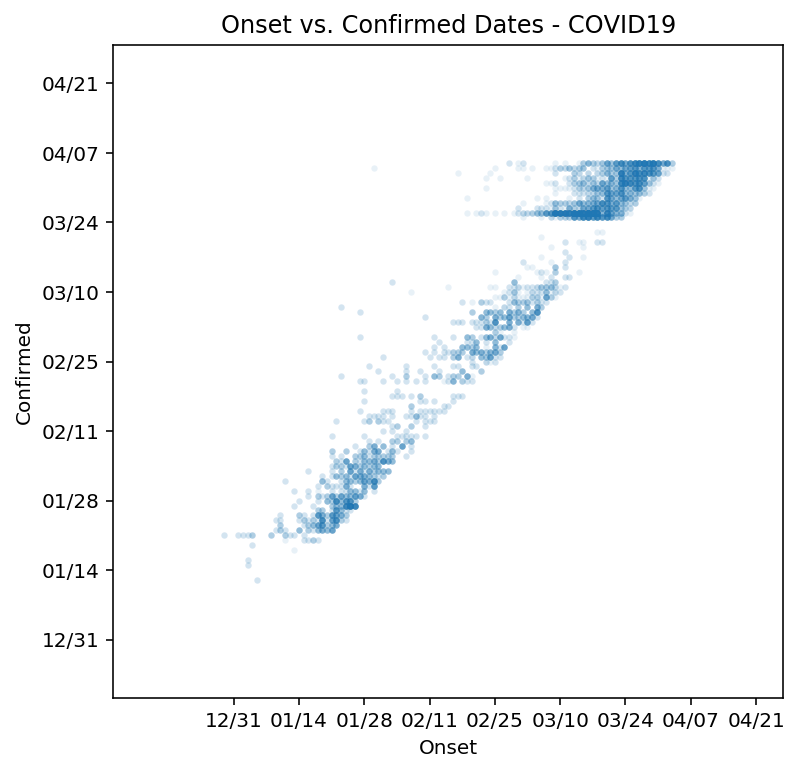

In [10]:
ax = patients.plot.scatter(
    title='Onset vs. Confirmed Dates - COVID19',
    x='Onset',
    y='Confirmed',
    alpha=.1,
    lw=0,
    s=10,
    figsize=(6,6))

formatter = mdates.DateFormatter('%m/%d')
locator = mdates.WeekdayLocator(interval=2)

for axis in [ax.xaxis, ax.yaxis]:
    axis.set_major_formatter(formatter)
    axis.set_major_locator(locator)

#### Calculate the Probability Distribution of Delay

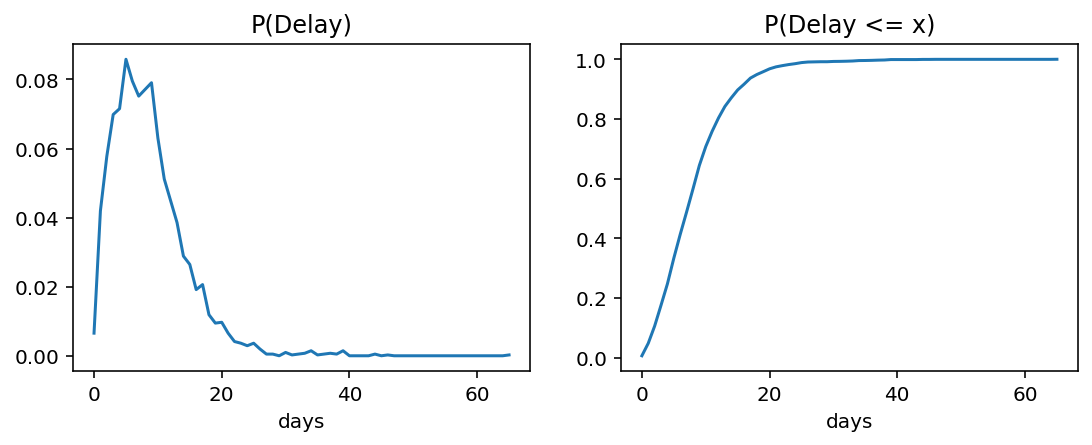

In [11]:
# Calculate the delta in days between onset and confirmation
delay = (patients.Confirmed - patients.Onset).dt.days

# Convert samples to an empirical distribution
p_delay = delay.value_counts().sort_index()
new_range = np.arange(0, p_delay.index.max()+1)
p_delay = p_delay.reindex(new_range, fill_value=0)
p_delay /= p_delay.sum()

# Show our work
fig, axes = plt.subplots(ncols=2, figsize=(9,3))
p_delay.plot(title='P(Delay)', ax=axes[0])
p_delay.cumsum().plot(title='P(Delay <= x)', ax=axes[1])
for ax in axes:
    ax.set_xlabel('days')

## A Single State

#### Select State Data

In [12]:

state = 'NY'
confirmed = states.xs(state).positive.diff().dropna()
confirmed.tail()

date
2020-05-09    2715.0
2020-05-10    2273.0
2020-05-11    1660.0
2020-05-12    1430.0
2020-05-13    2176.0
Name: positive, dtype: float64

### Translate Confirmation Dates to Onset Dates

Our goal is to translate positive test counts to the dates where they likely occured. Since we have the distribution, we can distribute case counts back in time according to that distribution. To accomplish this, we reverse the case time series, and convolve it using the distribution of delay from onset to confirmation. Then we reverse the series again to obtain the onset curve. Note that this means the data will be 'right censored' which means there are onset cases that have yet to be reported so it looks as if the count has gone down.

In [13]:
def confirmed_to_onset(confirmed, p_delay):

    assert not confirmed.isna().any()
    
    # Reverse cases so that we convolve into the past
    convolved = np.convolve(confirmed[::-1].values, p_delay)

    # Calculate the new date range
    dr = pd.date_range(end=confirmed.index[-1],
                       periods=len(convolved))

    # Flip the values and assign the date range
    onset = pd.Series(np.flip(convolved), index=dr)
    
    return onset


onset = confirmed_to_onset(confirmed, p_delay)

In [14]:
onset

2019-12-31      0.003880
2020-01-01      0.002667
2020-01-02      0.010427
2020-01-03      0.007032
2020-01-04      0.008972
                 ...    
2020-05-09    464.445684
2020-05-10    319.005577
2020-05-11    196.435015
2020-05-12    100.644520
2020-05-13     14.246363
Freq: D, Length: 135, dtype: float64

### Adjust for Right-Censoring

Since we distributed observed cases into the past to recreate the onset curve, we now have a right-censored time series. We can correct for that by asking what % of people have a delay less than or equal to the time between the day in question and the current day.

For example, 5 days ago, there might have been 100 cases onset. Over the course of the next 5 days some portion of those cases will be reported. This portion is equal to the cumulative distribution function of our delay distribution. If we know that portion is say, 60%, then our current count of onset on that day represents 60% of the total. This implies that the total is 166% higher. We apply this correction to get an idea of what actual onset cases are likely, thus removing the right censoring.

In [15]:
def adjust_onset_for_right_censorship(onset, p_delay):
    cumulative_p_delay = p_delay.cumsum()
    
    # Calculate the additional ones needed so shapes match
    ones_needed = len(onset) - len(cumulative_p_delay)
    padding_shape = (0, ones_needed)
    
    # Add ones and flip back
    cumulative_p_delay = np.pad(
        cumulative_p_delay,
        padding_shape,
        constant_values=1)
    cumulative_p_delay = np.flip(cumulative_p_delay)
    
    # Adjusts observed onset values to expected terminal onset values
    adjusted = onset / cumulative_p_delay
    
    return adjusted, cumulative_p_delay


adjusted, cumulative_p_delay = adjust_onset_for_right_censorship(onset, p_delay)

In [16]:
adjusted

2019-12-31       0.003880
2020-01-01       0.002667
2020-01-02       0.010427
2020-01-03       0.007032
2020-01-04       0.008972
                 ...     
2020-05-09    1875.978452
2020-05-10    1812.092287
2020-05-11    1849.538813
2020-05-12    2075.290000
2020-05-13    2176.000000
Freq: D, Length: 135, dtype: float64

Take a look at all three series: confirmed, onset and onset adjusted for right censoring.

In [17]:
cumulative_p_delay

array([1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       0.99975752, 0.99975752, 0.99975752, 0.99975752, 0.99975

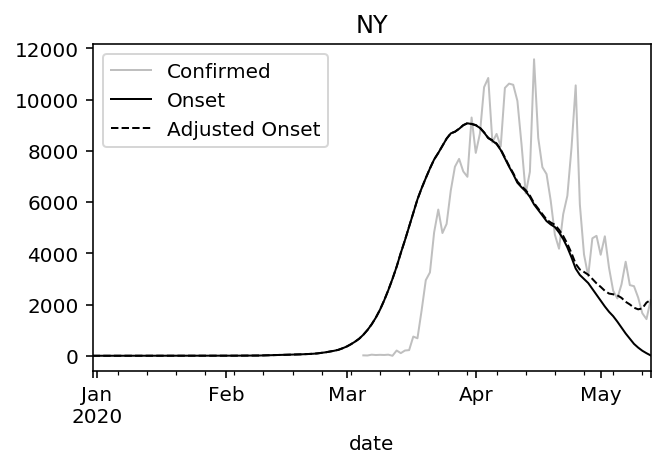

In [19]:
fig, ax = plt.subplots(figsize=(5,3))

confirmed.plot(
    ax=ax,
    label='Confirmed',
    title=state,
    c='k',
    alpha=.25,
    lw=1)

onset.plot(
    ax=ax,
    label='Onset',
    c='k',
    lw=1)

adjusted.plot(
    ax=ax,
    label='Adjusted Onset',
    c='k',
    linestyle='--',
    lw=1)

ax.legend();

## Sort for BMI

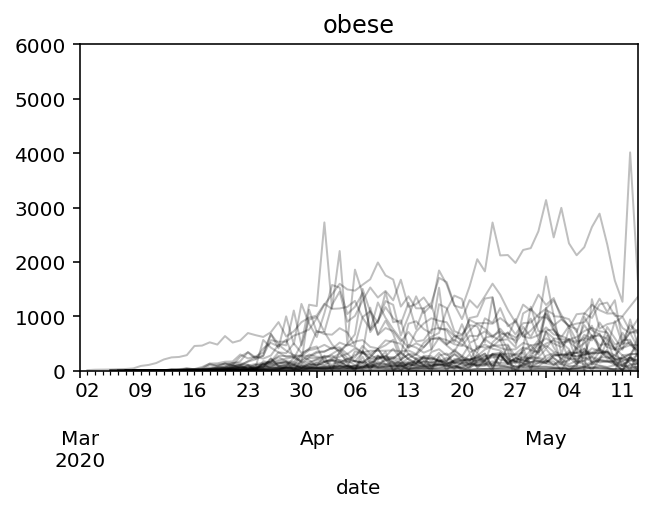

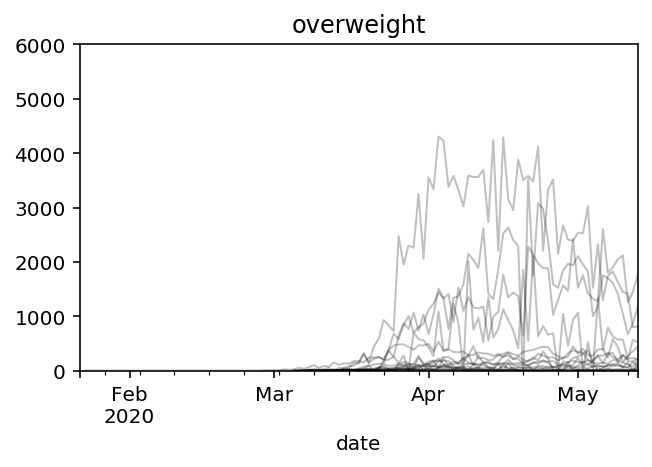

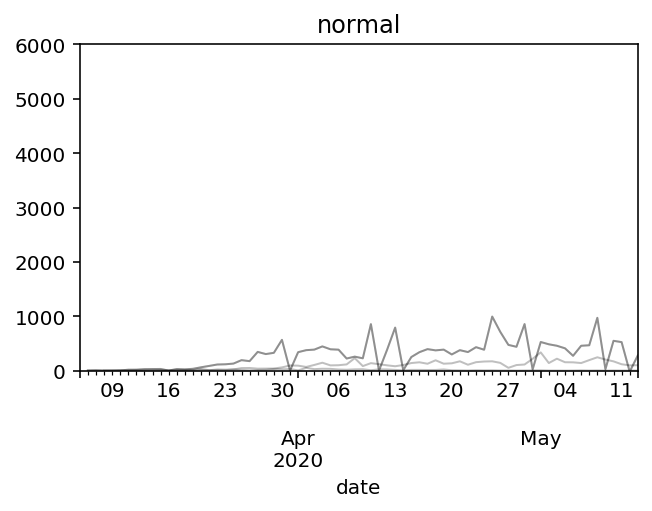

In [59]:
from datetime import datetime


BMI_region = pd.read_csv("states_and_BMI.csv", usecols=["Abbreviation:", "BMI_Status"])



BMI_status = dict()
for index, row in BMI_region.iterrows():
    
    if row[1] not in BMI_status:
        BMI_status[row[1]] = [row[0]]
    if row[1] in BMI_status:
        BMI_status[row[1]].append(row[0])


for obesity_level, region in BMI_status.items():
    fig, ax = plt.subplots(figsize=(5,3))
    for state in region:
        confirmed = states.xs(state).positive.diff()
        confirmed.tail()
        
        if state == "NY":
            continue
            #color = "red"
        else:
            color = "black"
        
        #set range of axis
        ax.set_ylim([0, 6000])
        
        now = datetime.now()
        now = now.strftime("%Y-%m-%d")
        ax.set_xlim(["2020-03-05", now])
        
        
        confirmed.plot(
            ax=ax,
            title=obesity_level,
            label=state,
            c=color,
            alpha=.25,
            lw=1,)
        #break

#confirmed.plot()
#adjusted.plot(
#    ax=ax,
#    label=state,
#    title="confirmed",
#    c='k',
#    alpha=.25,
#    lw=1)

#onset.plot(
#    ax=ax,
#    label='Onset',
#    c='k',
#    lw=1)

#adjusted.plot(
#    ax=ax,
#    label='Adjusted Onset',
#    c='k',
#    linestyle='--',
#    lw=1)

#ax.legend();

Let's have the model run on days where we have enough data ~last 50 or so

In [ ]:
#url = 'https://raw.githubusercontent.com/jasonong/List-of-US-States/master/states.csv'
#abbrev = pd.read_csv(url, index_col=['State'], squeeze=True)

#jhu_url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv'
#jhu = pd.read_csv(jhu_url)

#jhu = jhu.drop(columns=['UID', 'iso2', 'iso3', 'code3', 'FIPS', 'Admin2', 'Country_Region', 'Lat', 'Long_', 'Combined_Key'])
#jhu = jhu.set_index('Province_State')
#jhu.index = jhu.index.rename('region')
#jhu = jhu.drop([
#     'American Samoa',
#     'Guam',
#     'Northern Mariana Islands',
#     'Puerto Rico',
#     'Virgin Islands',
#     'Diamond Princess',
#     'Grand Princess'])

#jhu.index = pd.Index(jhu.index.to_series().replace(abbrev).values, name='region')
#jhu.columns = pd.to_datetime(jhu.columns)
#jhu = jhu.groupby('region').sum()
#jhu = jhu.stack().sort_index()

#state = 'VT'
#ax = jhu.xs(state).diff().plot(label='JHU', color='k', legend=True, title=state)
#jhu.xs('AK').diff().rolling(7).mean().plot(ax=ax)
#states.xs(state).positive.diff().plot(ax=ax, figsize=(6,4), linestyle=':', label='Covidtracking', legend=True)
#ax.set_xlim(pd.Timestamp('2020-03-01'),None)

In [ ]:
#url = 'https://raw.githubusercontent.com/epiforecasts/covid-regional/3ad63ea1acceb797f0628a8037fc206342d267e7/united-states/regional-summary/rt.csv'
#
#epf = pd.read_csv(url, parse_dates=['date'])
#epf.region = epf.region.replace(abbrev)
#epf = epf.set_index(['region', 'date']).sort_index()
#epf = epf.drop(['Guam', 'Puerto Rico'])
#
#epf_lookup = {}
#for idx, grp in epf.groupby('region'):
#    epf_lookup[idx]=grp
#    epf_grp = epf_lookup[idx]
#    
#    plot_rt(idx, result.droplevel(0), ax)
#    plot_rt(idx, epf_grp.droplevel(0), ax, c=(1,0,0,1))